# Bayesian/Frequentist Tutorial

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymer4.simulate import simulate_lm, simulate_lmm
import os
from glob import glob
%matplotlib inline

In this notebook we demo how to perform the same set of analyses using a frequentist approach and a bayesian approach.  
We'll perform two sets of analyses:  
1) Simple between groups t-test (i.e. univariate regression with dummy-coding)   
2) Multi-level multivariate regression model (with two predictors)  
We'll estimate the frequentist statistics using [pymer4](http://eshinjolly.com/pymer4/).  

## Generate t-test data

In [86]:
a = np.random.normal(5,2,1000)
b = np.random.normal(8,2.5,1000)
df = pd.DataFrame({'Group':['a']*1000 + ['b']*1000,'Val':np.hstack([a,b])})

In [87]:
df.groupby('Group').describe()

Val                                                              \
        count      mean       std       min       25%       50%       75%   
Group                                                                       
a      1000.0  4.980000  2.014565 -0.732913  3.518155  5.013075  6.387810   
b      1000.0  8.129861  2.559710  0.074312  6.338794  8.150710  9.877882   

                  
             max  
Group             
a      11.466186  
b      16.458058

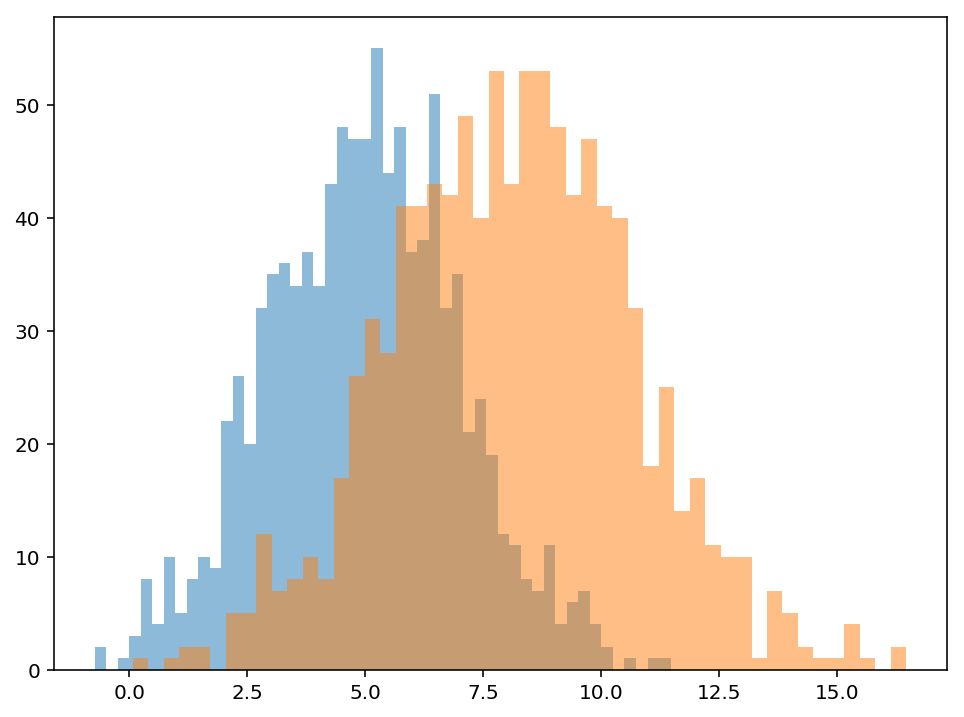

In [88]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(a,alpha=.5,bins=50);
ax.hist(b,alpha=.5,bins=50);

### Frequentist  
Since this analysis is relateively straightforward we can perform a between groups t-test using scipy

In [89]:
from scipy.stats import ttest_ind
ttest_ind(b,a)

Ttest_indResult(statistic=30.57888496642679, pvalue=8.697871985710429e-169)

We can also set this up as a dummy-coded univariate regression model which is identical

In [90]:
# Using the pymer4 package, but we could have used statsmodels instead
from pymer4.models import Lm
model = Lm('Val ~ Group',data=df)
model.fit()

Formula: Val ~ Group

Family: gaussian

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2000	 R^2: 0.319	 R^2_adj: 0.318

Log-likelihood: -4505.582 	 AIC: 9015.163	 BIC: 9026.365

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,4.98,4.837,5.123,0.073,1998,68.371,0.0,***
Group[T.b],3.15,2.948,3.352,0.103,1998,30.579,0.0,***


### Bayesian
We can compute the equivalent dummy-coded regression model to estimate with bambi and the pymc3 backend

In [91]:
from bambi import Model
import pymc3 as pm
import bambi

b_model = Model(df)
res_b = b_model.fit('Val ~ Group',samples=1000,chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 4,542.7:  22%|██▏       | 11113/50000 [00:06<00:22, 1709.95it/s]
Convergence archived at 11300
Interrupted at 11,299 [22%]: Average Loss = 5,277
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Val_sd_interval__, Group, Intercept]
100%|██████████| 1500/1500 [00:01<00:00, 844.89it/s]


In [93]:
# Here's the setup for the model
b_model.backend.model

/Users/Esh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Esh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Esh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


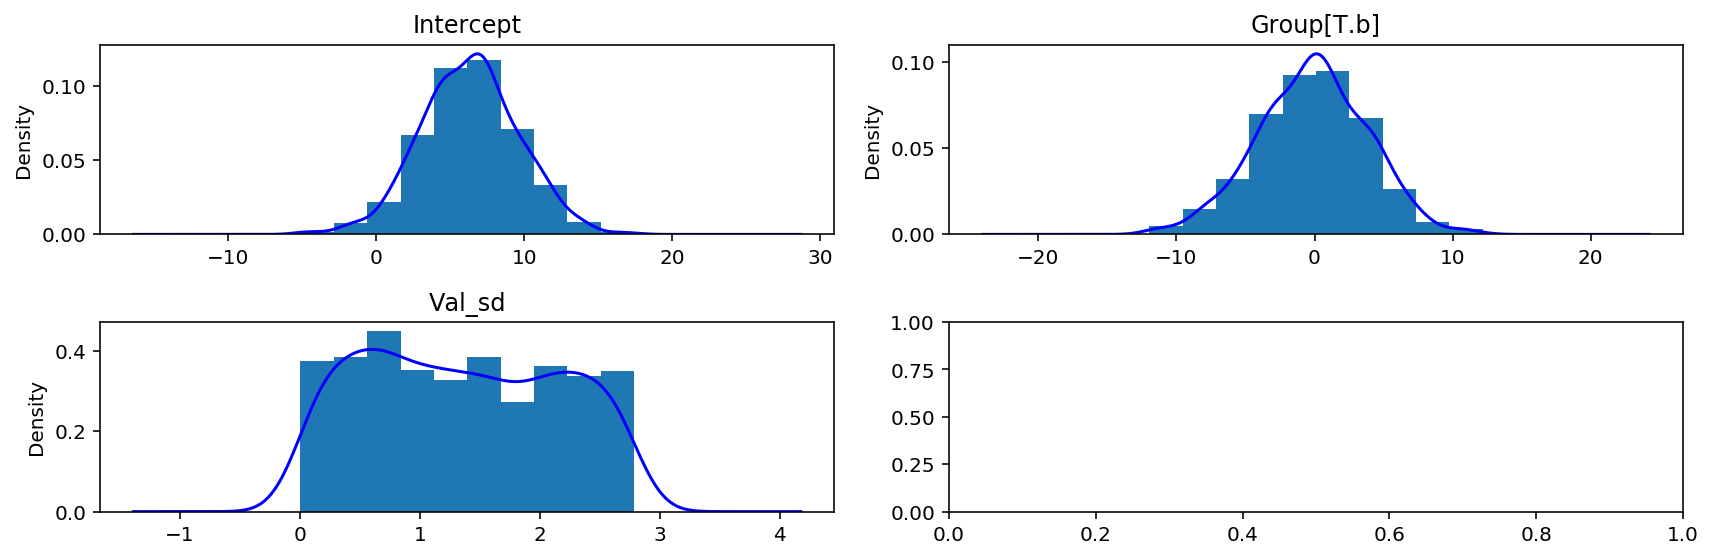

In [94]:
# Model priors
b_model.plot();

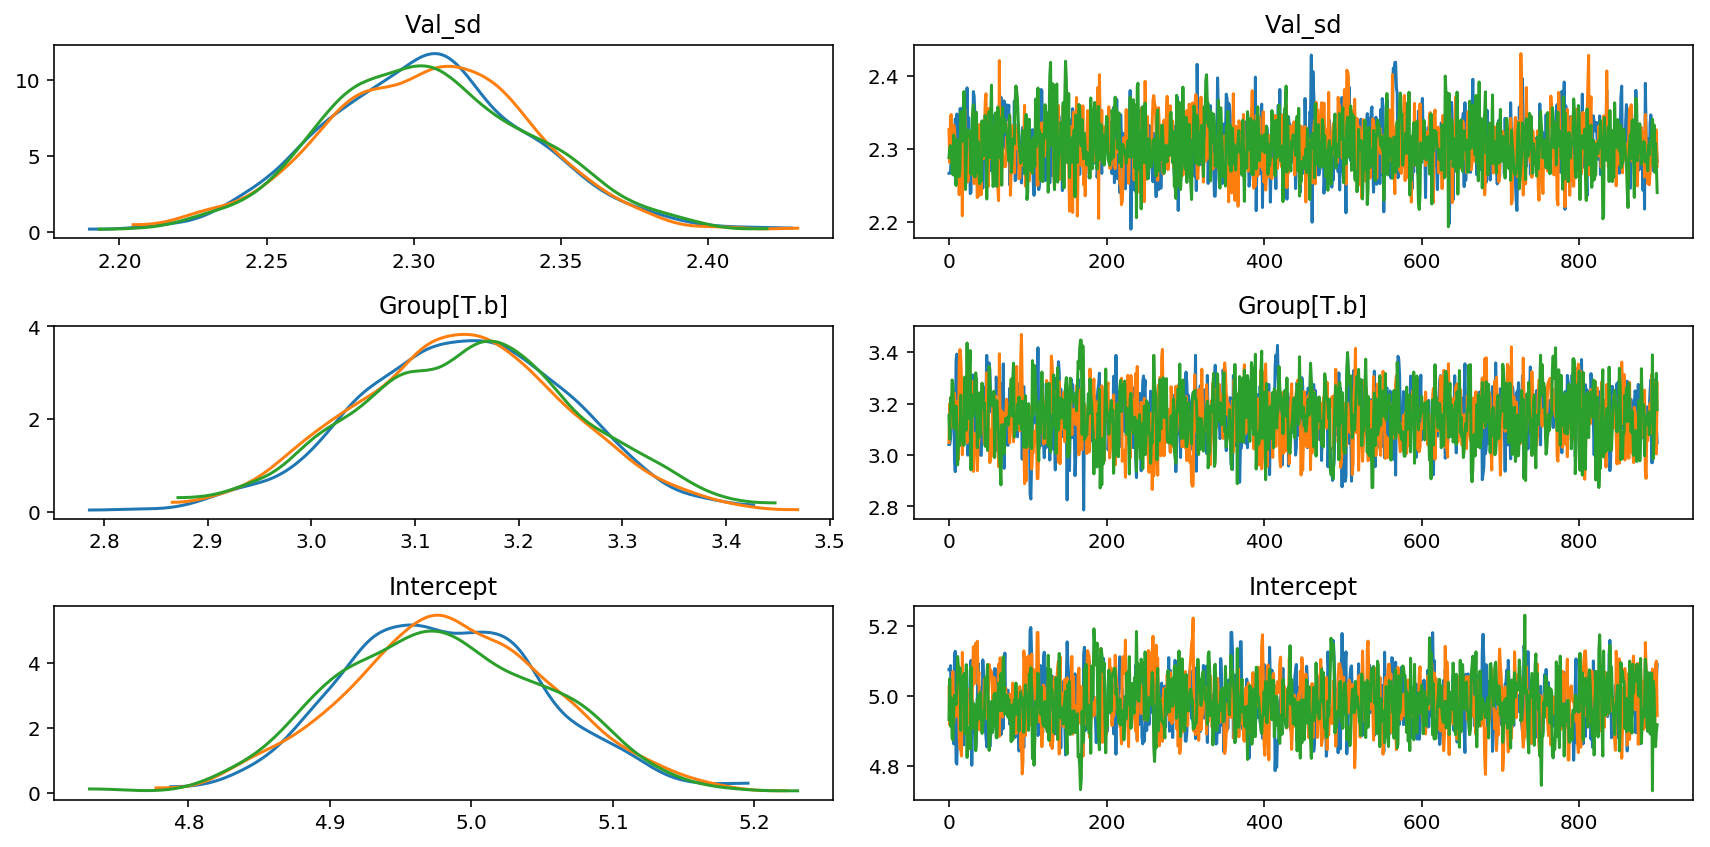

In [95]:
#Posterior plots removing first 100 samples for burn-in
res_b[100:].plot();

In [96]:
res_b[100:].summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Group[T.b],3.145886,0.104301,2.936774,3.344979,1493,1.000435
Intercept,4.981076,0.072968,4.850235,5.129755,1415,1.000364
Val_sd,2.304672,0.035844,2.235005,2.376468,1881,0.999520


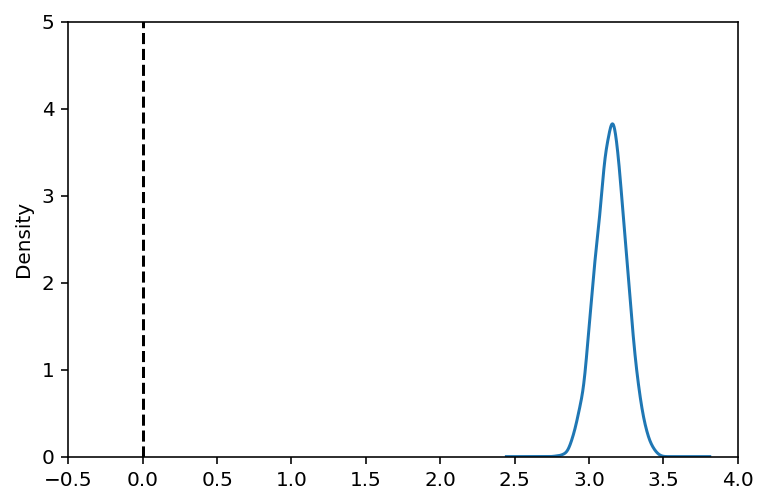

In [97]:
#Grab just the posterior of the term of interest (group)
group_posterior = res_b.to_df()['Group[T.b]']
ax = group_posterior.plot(kind='kde',xlim=[-.5,4],ylim=[0,5])
ax.axvline(0,0,3,linestyle='--',color='k');

In [98]:
#Probabiliy that posterior is > 0
(group_posterior > 0).mean()

1.0

## Generate multi-level regression data

Generate data for a multivariate regression model with random intercepts and slope effect for each group

In [51]:
# Simulate some multi-level data with pymer4
from pymer4.simulate import simulate_lmm
df, blups, coefs = simulate_lmm(num_obs=500, num_coef=2, num_grps=25, coef_vals=[5,3,-1])
df.head()
blups.head()

,DV,IV1,IV2,Group
0,6.304926,-0.610891,-1.567181,1.0
1,9.350987,1.118879,-0.072492,1.0
2,3.917564,-0.919558,-1.009021,1.0
3,2.390540,-1.832521,-0.850452,1.0
4,-0.622128,-1.382818,0.737954,1.0


,Intercept,IV1,IV2
Grp1,5.181938,2.930271,-0.937849
Grp2,5.176513,2.789747,-1.283368
Grp3,5.155200,3.143078,-0.891992
Grp4,5.215888,3.263981,-1.136450
Grp5,4.754923,2.589841,-0.879531


### Frequentist multi-level model

In [52]:
# Fit multi-level model using pymer4 (lmer in R)
from pymer4.models import Lmer
model = Lmer('DV ~ IV1 + IV2 + (IV1 + IV2|Group)',data=df)
model.fit()

Formula: DV ~ IV1 + IV2 + (IV1 + IV2|Group)

Family: gaussian	 Inference: parametric

Number of observations: 12500	 Groups: {'Group': 25.0}

Log-likelihood: -17812.104 	 AIC: 35624.208

Random effects:

                 Name    Var    Std
Group     (Intercept)  0.079  0.281
Group             IV1  0.094  0.307
Group             IV2  0.070  0.265
Residual               0.989  0.995

               IV1  IV2   Corr
Group  (Intercept)  IV1  0.152
Group  (Intercept)  IV2 -0.081
Group          IV1  IV2 -0.329

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),5.099,4.987,5.210,0.057,24.001,89.480,0.0,***
IV1,3.049,2.927,3.170,0.062,23.962,49.169,0.0,***
IV2,-0.988,-1.093,-0.883,0.054,24.006,-18.386,0.0,***


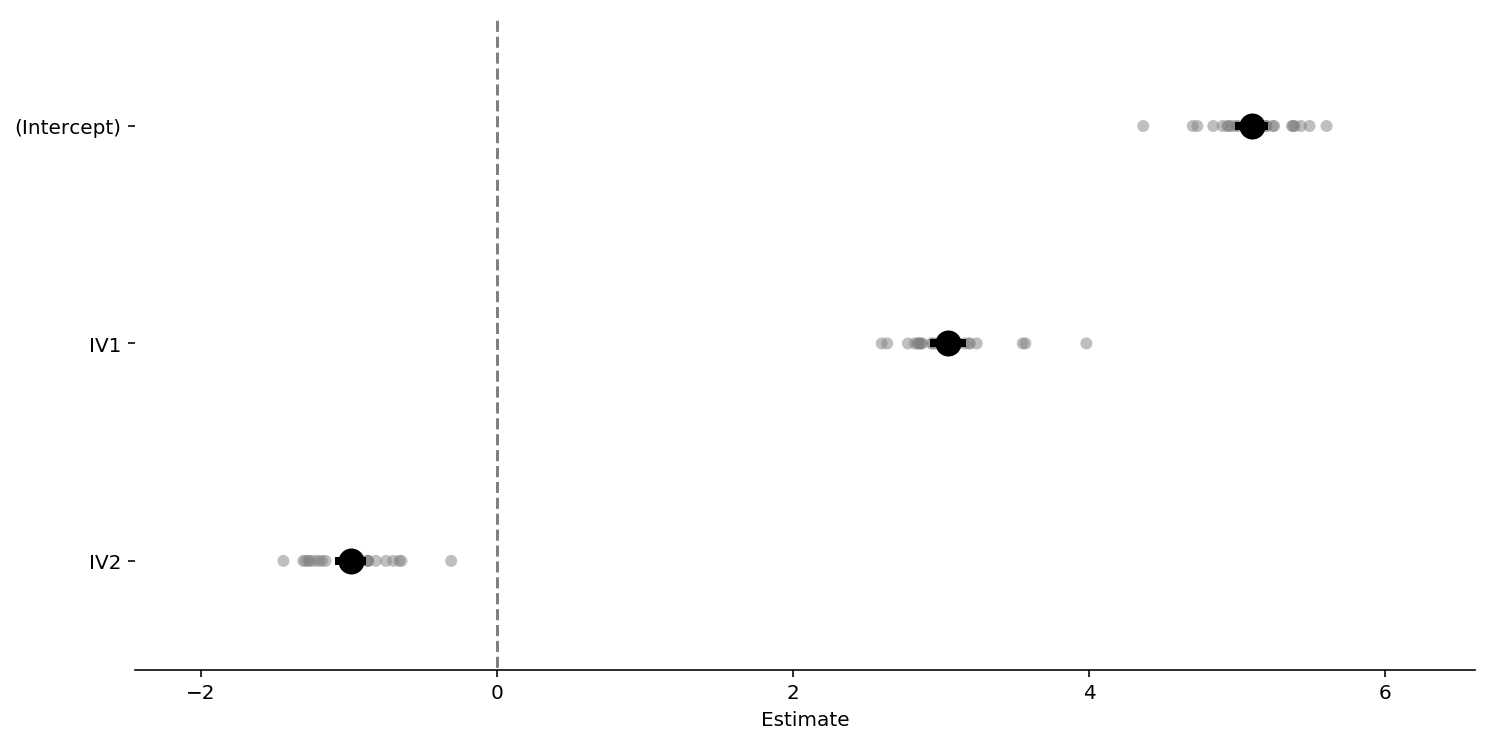

In [56]:
# Plot coefficients and the group BLUPs as well
model.plot_summary();

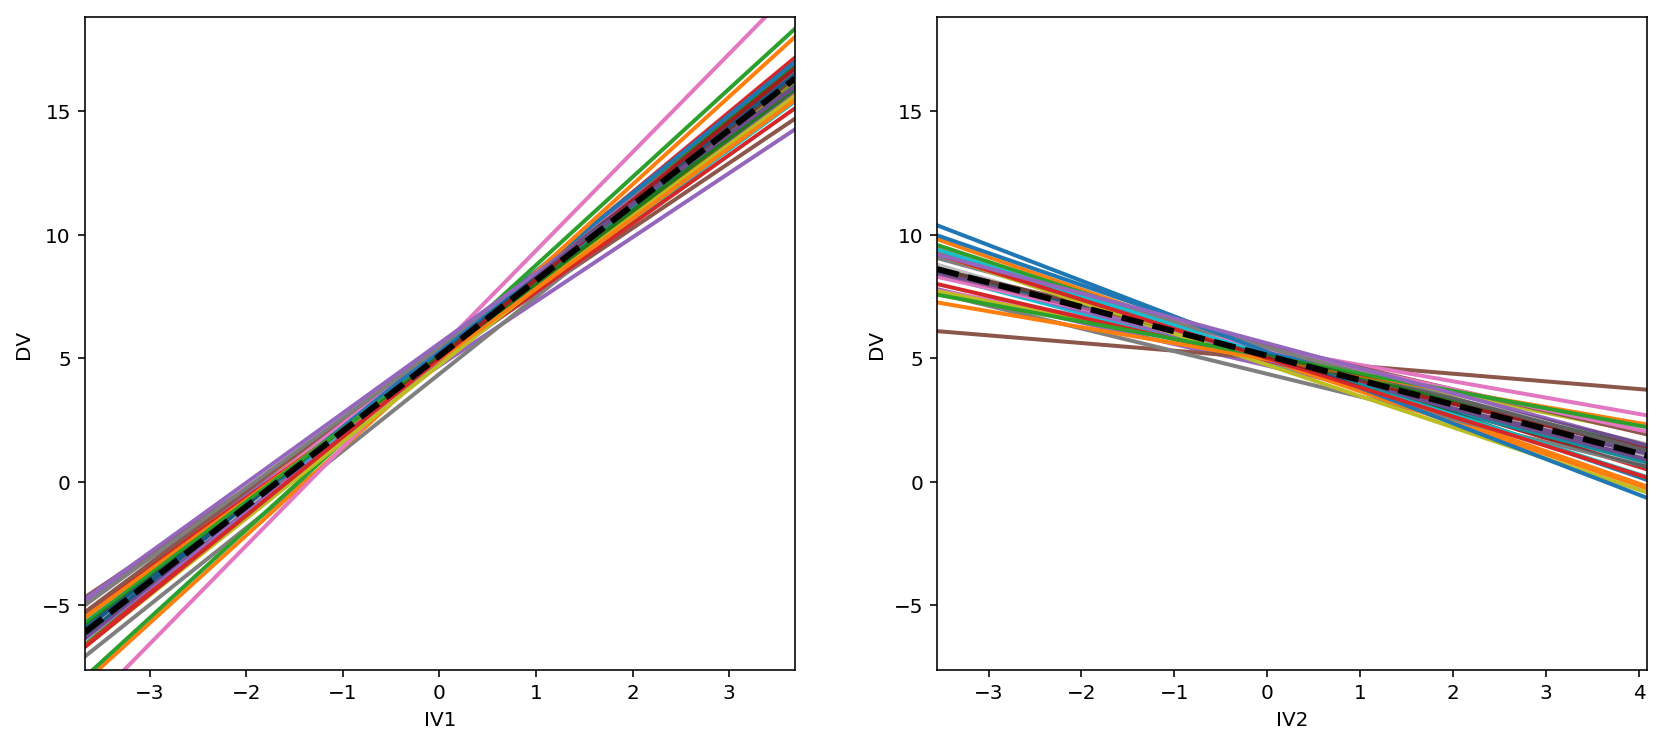

In [81]:
# Alternatively visualize coefficients as regression lines with BLUPs overlaid
f,axs = plt.subplots(1,2,figsize=(14,6));
model.plot('IV1',ax=axs[0],);
model.plot('IV2',ax=axs[1]);

### Bayesian multi-level model

In [57]:
b_model = Model(df)
results = b_model.fit('DV ~ IV1 + IV2',random=['IV1+IV2|Group'],samples=1000,chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 17,878:  57%|█████▋    | 28265/50000 [00:41<00:32, 675.56it/s]
Convergence archived at 28300
Interrupted at 28,299 [56%]: Average Loss = 22,176
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [DV_sd_interval__, IV2|Group_offset, IV2|Group_sd_log__, IV1|Group_offset, IV1|Group_sd_log__, 1|Group_offset, 1|Group_sd_log__, IV2, IV1, Intercept]
100%|██████████| 1500/1500 [02:04<00:00, 12.04it/s]
The number of effective samples is smaller than 25% for some parameters.


In [59]:
b_model.backend.model

/Users/Esh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Esh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Esh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Esh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Esh/anaconda3/lib/python3.6/site-pack

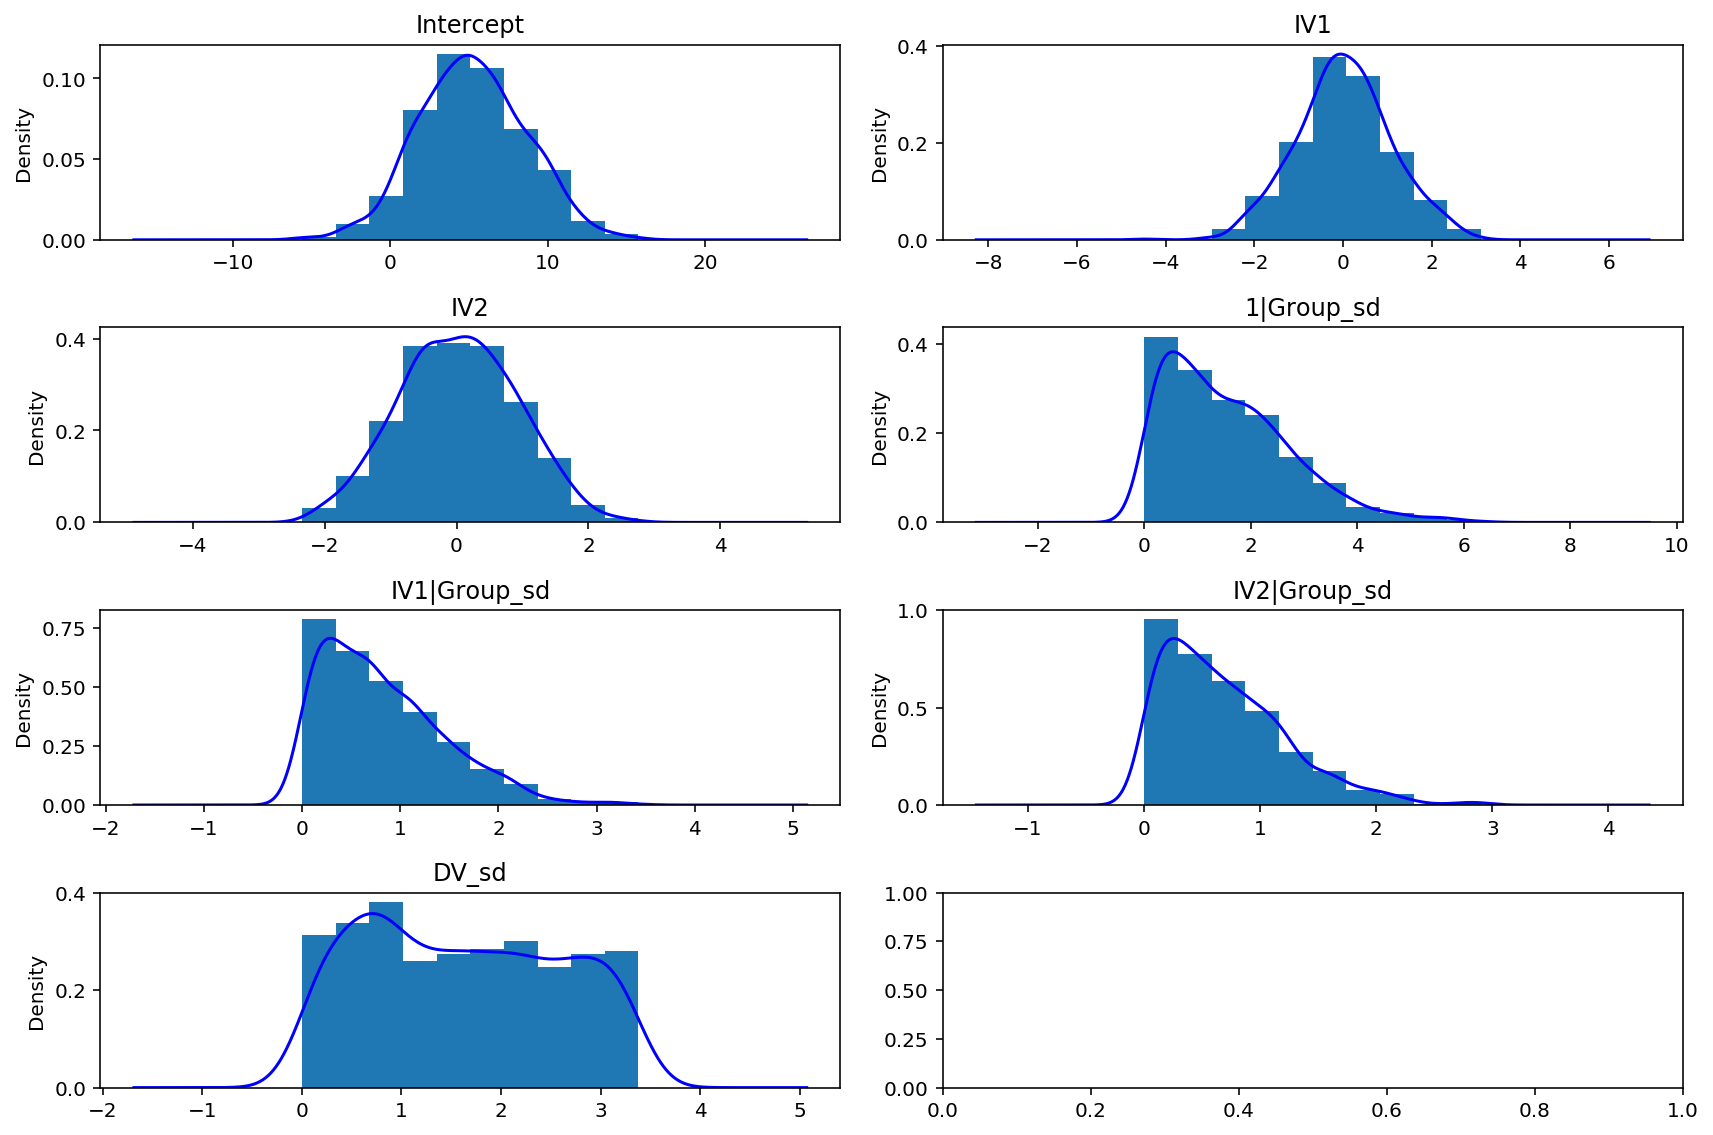

In [60]:
# Plot priors
b_model.plot();

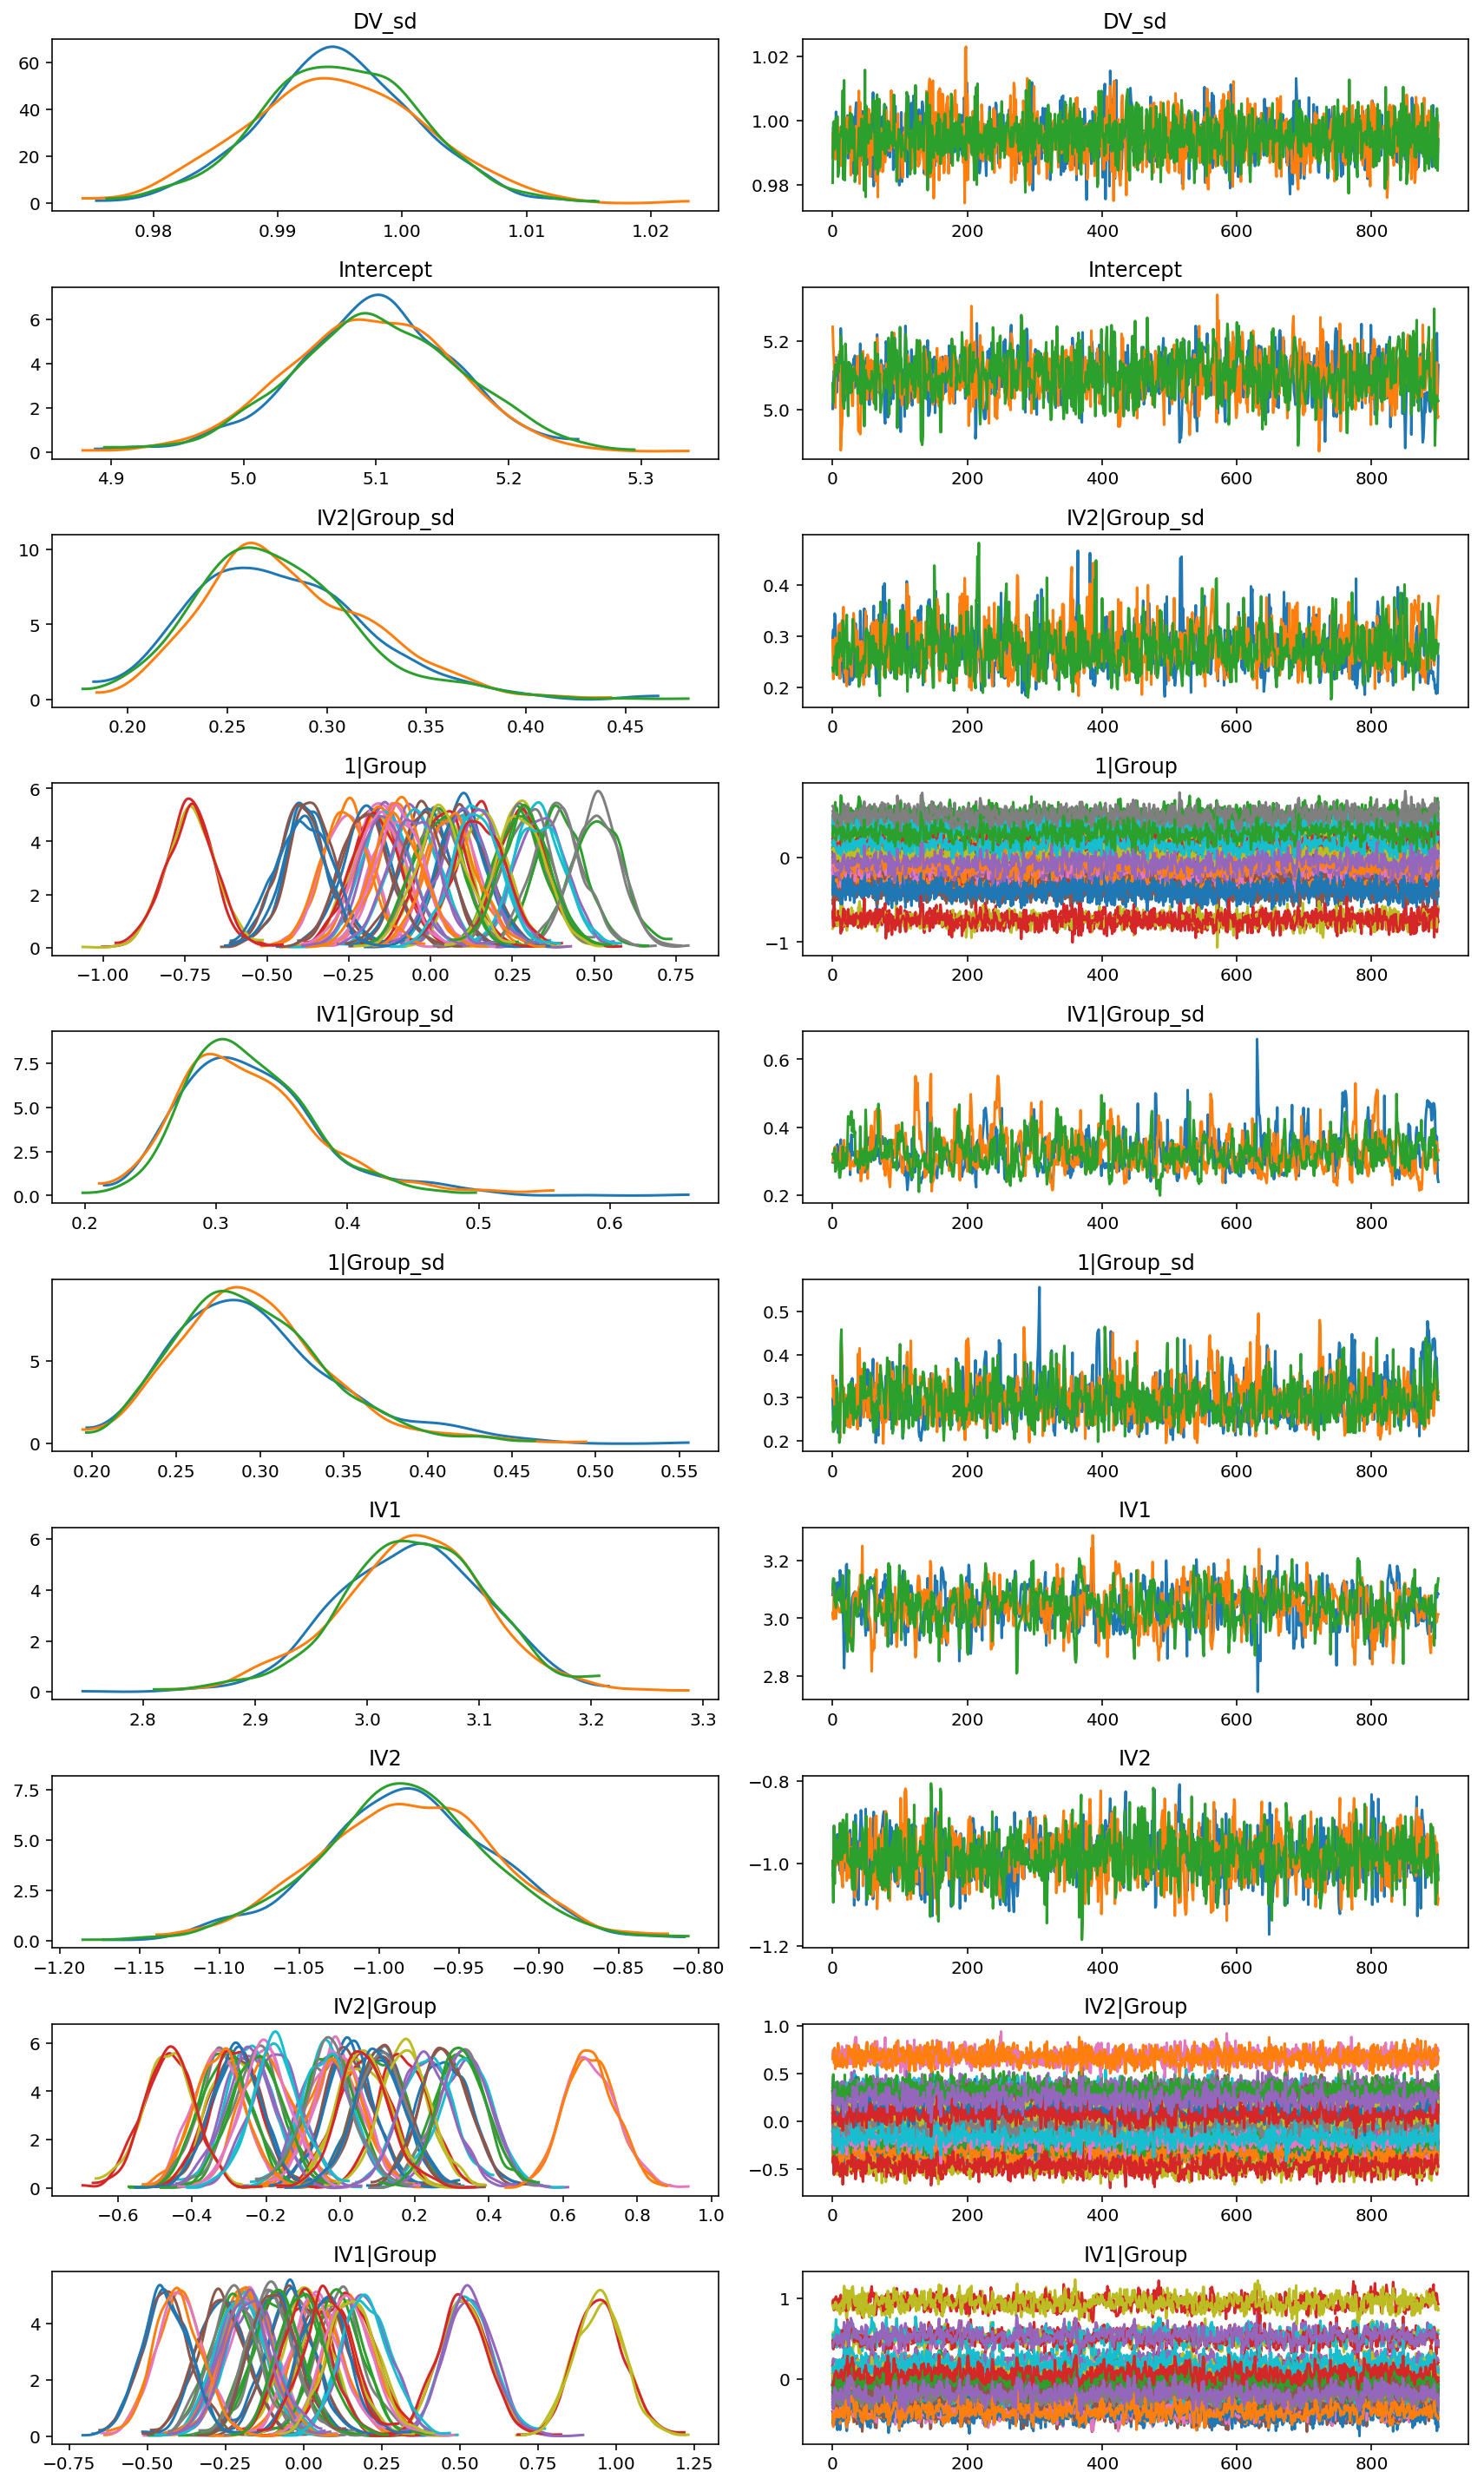

In [61]:
#Plot posteriors
results[100:].plot();

In [63]:
results[100:].summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|Group_sd,0.296123,0.046973,0.213154,0.394314,569,1.000344
DV_sd,0.994745,0.006591,0.981409,1.007187,2700,0.999791
IV1,3.039772,0.065466,2.905801,3.164539,592,0.999766
IV1|Group_sd,0.325975,0.052205,0.236429,0.434760,500,0.999868
IV2,-0.983000,0.054667,-1.102063,-0.885895,1421,0.999686
IV2|Group_sd,0.277549,0.043083,0.200689,0.365828,977,1.002444
Intercept,5.098220,0.062943,4.972299,5.217102,1570,1.000099


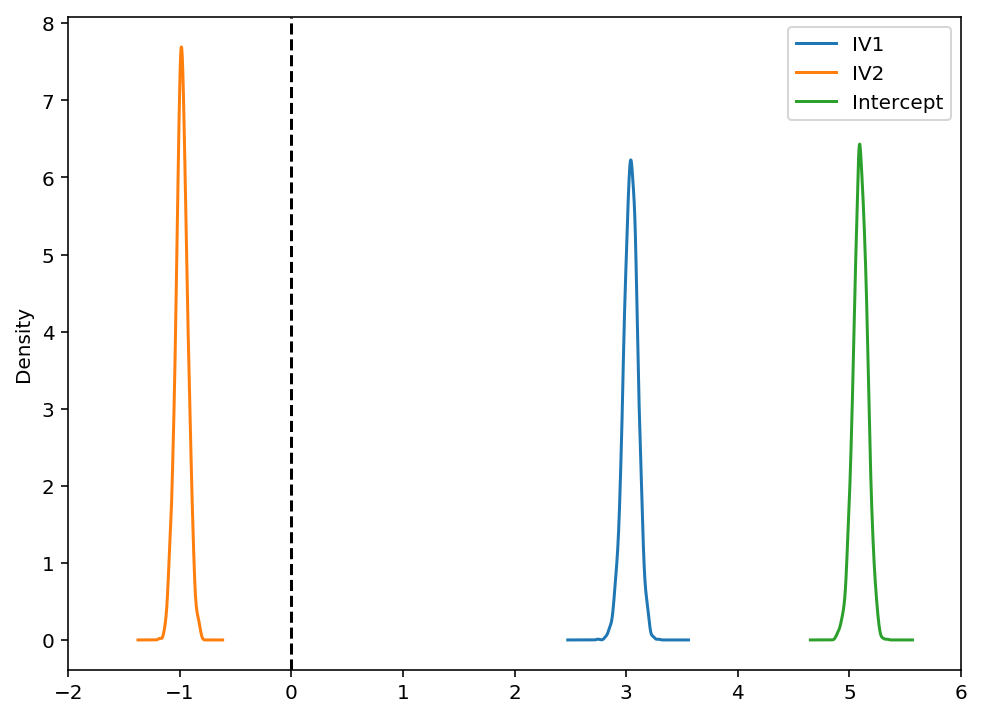

In [76]:
#Plot all posterior on the same plot
results_df = results.to_df()
fixed_terms = [col for col in results_df.columns if '|' not in col and 'sd' not in col]
results_df = results_df[fixed_terms]
results_df.plot(kind='kde',xlim=[-2,6],figsize=(8,6)).axvline(0,color='k',linestyle='--')

Because we used pymc3 for the backend estimation in bambi, we have access to few extra goodies. Here we make a forest plot similar to the one above for the frequentist model, but with 95% credible intervals instead

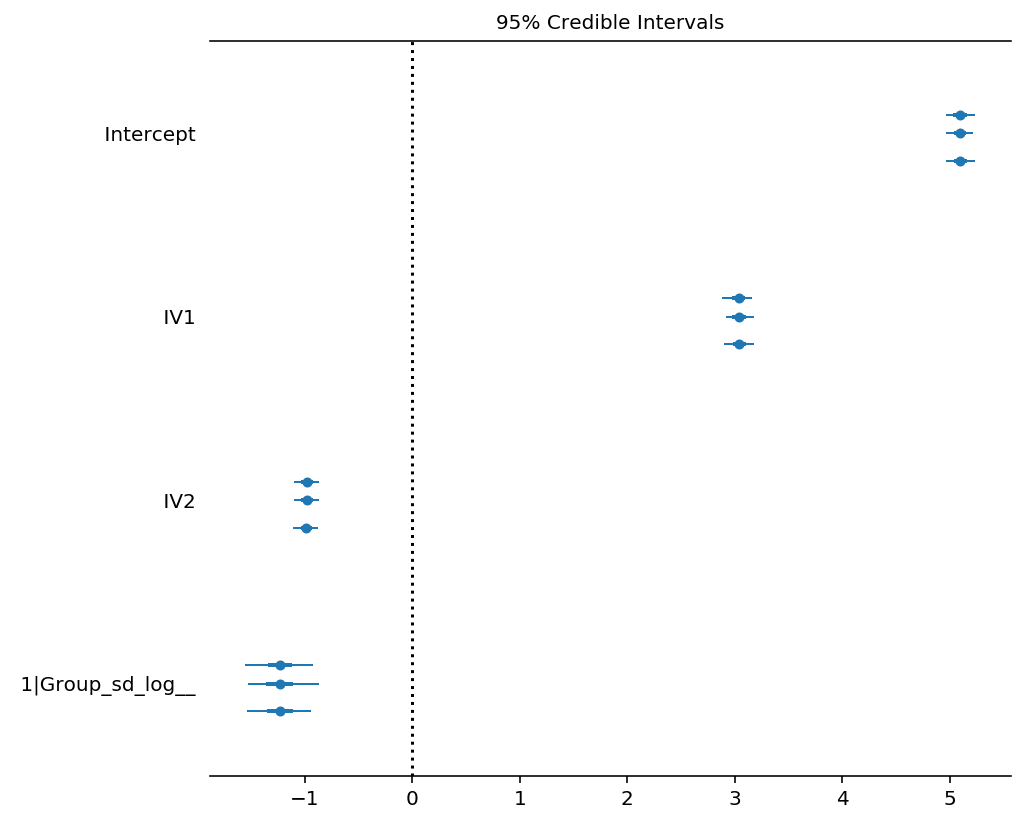

In [73]:
# Credible interval plot using pymc3
# Line line is 95% credible interval calculated as higher posterior density
# Inter quartile range is thicker line
# Dot is median
f,ax = plt.subplots(1,1,figsize=(8,6))
pm.forestplot(b_model.backend.trace,varnames=list(map(str,b_model.backend.model.vars[:4])),rhat=False)

We can also plot the posterior overlayed with a region of practical equivalence (ROPE), i.e. range of values that were the coefficients to fall into, we might interpret them differently. 
We can see that all our posterior distributions fall outside of this range.

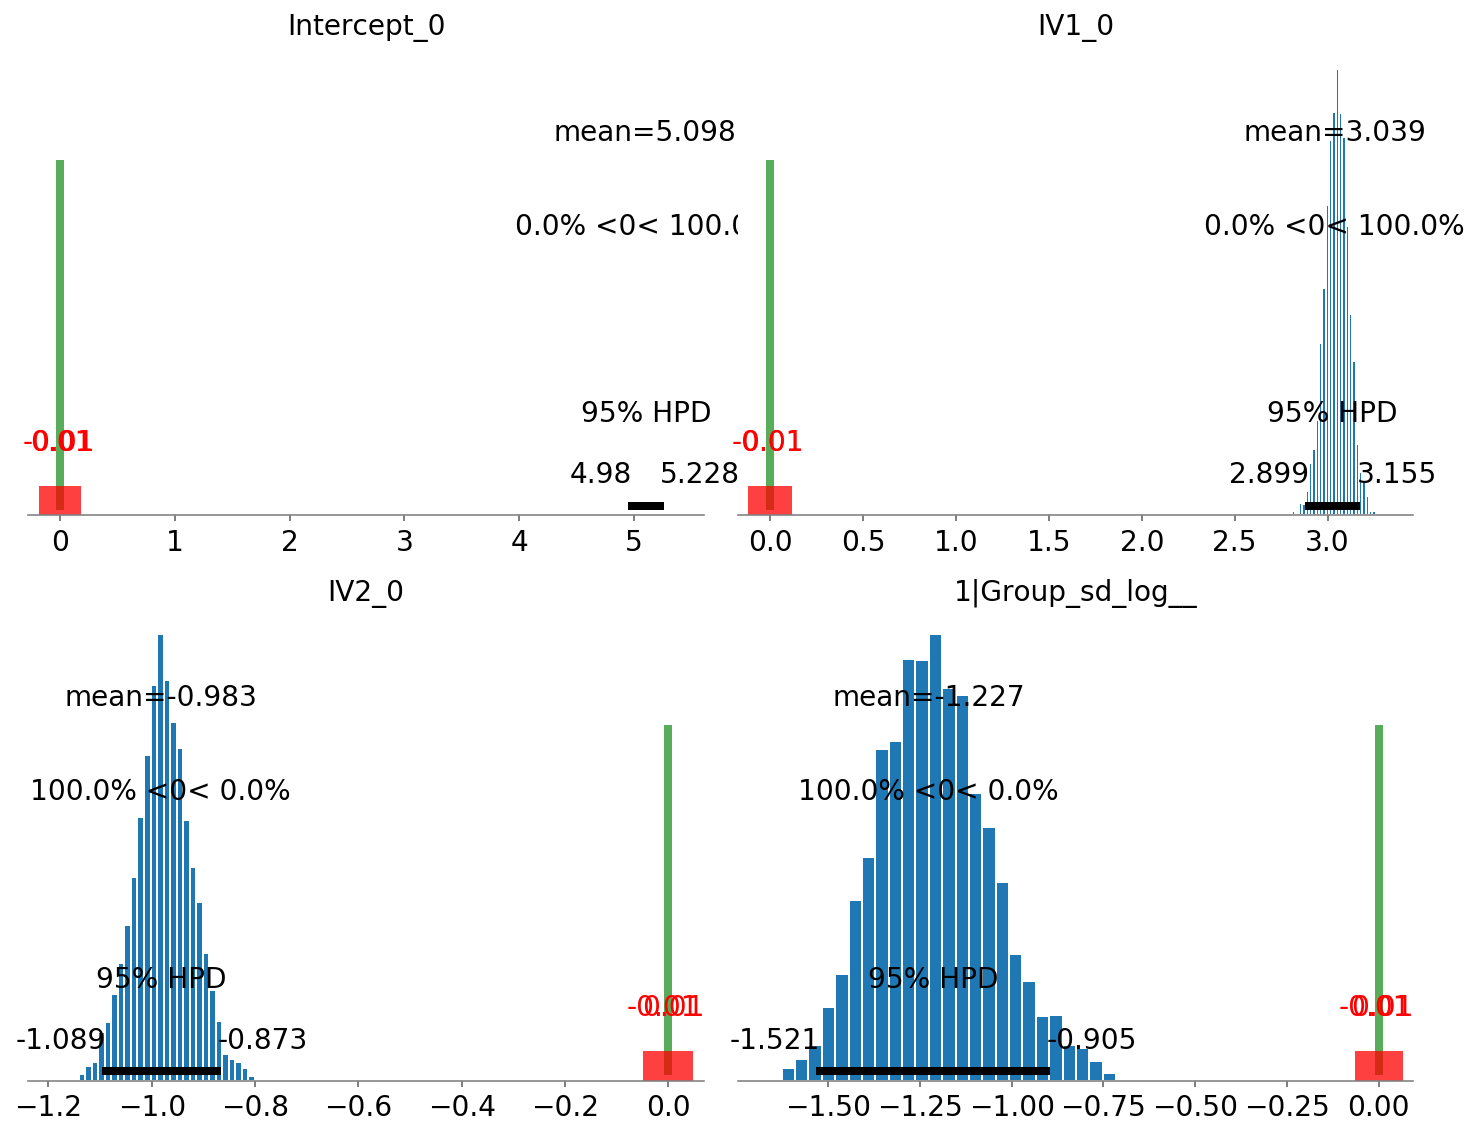

In [75]:
# Show credible interval cutoffs, and also overlay region of practical equivalence (arbitrary, in this case close enough to 0 to not matter)
pm.plot_posterior(b_model.backend.trace,
                  varnames=list(map(str,b_model.backend.model.vars[:4])),
                  ref_val=0,
                  text_size = 14,
                  rope=[-.01,.01],
                  figsize=(10,8));